### Experiments to demonstrate that weights evolve via D2 when given pure signal and zero noise 
The weights of a neural network will shift according to D2(x) := s(x)\*(d/dt s(x)) when the network computes activations using sigmoidal nonlinear function s(x) such as tanh. This is simple application of backpropagation. To support this claim, this notebook runs a tiny experiment that compares analytic predictions of the theory with observed reality, more as a sanity check and source of nice graphs than anything else.

To simplify the analysis without a loss of generality, we substitute changing weights with changing weights-divided-by-x-value, dubbed v or v_i. 
We calculate the gradient signal received by a vi, i.e. the gradient signal received by 'weight mod x_j input', which only vertically scales our results and thus isn't important to our questions of whether weights follow D2 or not. A tensorflow network is repeatedly re-initialized with a weight and we calculate the backpropagated signal given the network's computed prediction and the actual answer, y. These are collected into a graph do determine if the analytic prediction (signal follows D2) matches up with the observed reality (how does a weight mod x change under backprop).

In [1]:
%matplotlib inline
# ^ enables usage of matplotlib and furthermore enables displaying it in the notebook

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f043txkk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

Manually create D2 and D4 functions for analytic predictions:

In [430]:
def tanh(x): return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def d2_tanh(x,y=0): return -(y-tanh(x))*(1-tanh(x)**2) 
def sech(x): return 2/(np.exp(x)+np.exp(-x))
def d4_tanh__(x,y=0): return -2*sech(x)**2*tanh(x) - 6*sech(x)**4*tanh(x) + 6*sech(x)**2*tanh(x)**3
def d4_tanh(x,y=0): return -2*sech(x)**4 *(y- 3*tanh(x)) + 2*sech(x)**2*tanh(x)*(1+2*y*tanh(x)-3*tanh(x)**2)

# ^ -2 sech^4(x) (y - 3 tanh(x)) + 2 sech^2(x) tanh(x) (1 + 2 y tanh(x) - 3 tanh^2(x))


Plotters convenience function:

In [450]:
def Plot(f, vals=V_values, color=None, lw=2): 
    if color==None: plt.plot(vals, [f(v) for v in vals], linewidth=lw)
    else: plt.plot(vals, [f(v) for v in vals], color=color, linewidth=lw)
def PlotAxes(xbounds=[-1,1], ybounds=[-1,1], color=[0,0,0,0.3]):
    plt.plot([0,0], ybounds, '--', color=color)
    plt.plot(xbounds, [0,0], '--', color=color)

Sanity check; plot tanh, its D2, its D4

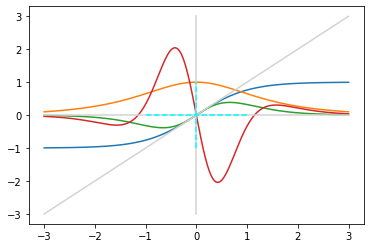

In [251]:
V_values = np.linspace(-3,3,100*(3--3)+1)

Plot(tanh)
Plot(sech)
Plot(d2_tanh)
Plot(d4_tanh)
Plot(lambda x:0, color='lightgray')
Plot(lambda x:x, color='lightgray')
plt.plot([0,0],[-3,3], color='lightgray')
#PlotAxes([-1,1],[-1,1],'cyan')

start of Section 1. First, delimit parameters; concurrently, initialize network;

In [236]:
# delimit parameters
Nonlinearities = [ ('tanh',tanh) ]                  # s_counter
# Y_values = [0,-1,1]                                 # y_counter
Y_values = list(np.linspace(-1,1,9))
V_values = np.linspace(-3,3,100*(3--3)+1)           # v_counter
# V_values = np.linspace(-3,3,14)           # dev
X_data = [ np.ones(v.shape) for v in V_values ]     # x_counter

learning_rate=1e0
V_values[:1], V_values.shape

(array([-3.]), (601,))

In [ ]:
def Set_weights(layer, weights):
    layer.set_weights([np.expand_dims(weights,0).T])
    
# initialize a network whose weights we manually set
def init_manual_model(nonlinearity, weight_value, learning_rate=0.01):
    nonlinearity_name, nonlinearity_function=nonlinearity
    model = Sequential()
    model.add(
        Dense(
            1, # num output units
            kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
            input_shape=(1,),
            activation=nonlinearity_name,
            use_bias=False,
        )
    )
    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    Set_weights(model.layers[0], weight_value)
    return model
test_model_init=init_manual_model(Nonlinearities[0], V_values[:1])
# [l.get_config() for l in test_model_init.layers]


In [237]:
def query_manual_model():
    dev_model=init_manual_model(Nonlinearities[0], np.zeros((1,))) # tmp: only combo
    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []  # tuple of indices counter-coords then data (weight, change)
    weights_to_changes_tensor = np.empty( (len(Y_values), 1, len(Nonlinearities), V_values.shape[0], 2 ) )

    # counters. vi: different values of vi
    
    
    for y_counter in range(len(Y_values)):
#      for x_counter in range(len(X_data)):
     for x_counter in range(1):
      for s_counter in range(len(Nonlinearities)):
       for v_counter in range(V_values.shape[0]):
        tensor_coords = (y_counter, x_counter, s_counter, v_counter)
        Set_weights(dev_model.layers[0], V_values[v_counter:v_counter+1])
        
        weights_retreiver = LambdaCallback( \
                on_epoch_begin=lambda batch, logs: weights_inbox.append( dev_model.layers[0].get_weights()[0]))
        changes_retriever = LambdaCallback( 
                on_epoch_end  =lambda batch, logs: changes_inbox.append( dev_model.layers[0].get_weights()[0]))        
        dev_model.fit(
            np.array([ X_data[0] ]),     # one datapoint for now   x_counter
            np.array([ Y_values[y_counter] ]),   # one datapoint for now.  y_counter
            batch_size=1,
            epochs=1,
            callbacks=[weights_retreiver, changes_retriever], 
            verbose=0
        )
        change = changes_inbox[-1]-weights_inbox[-1]
        weights_to_changes.append( (weights_inbox[-1][0][0], change[0][0]) )
        weights_to_changes_tensor[y_counter, x_counter, s_counter, v_counter, :] = np.array([weights_inbox[-1][0][0], change[0][0]])
        if (v_counter % int(V_values.shape[0]//10) == 0 and V_values.shape[0]>100) or v_counter==V_values.shape[0]-1:
            print('iteration '+str(v_counter)+'/'+str(V_values.shape[0])+' done; '+str(tensor_coords))

#     print(weights_inbox)
#     print()
#     print(changes_inbox)
#     print()
#     print(weights_to_changes)
    print('done')
    return weights_to_changes, weights_to_changes_tensor

wtc,wtct=query_manual_model()

iteration 0/601 done; (0, 0, 0, 0)
iteration 60/601 done; (0, 0, 0, 60)
iteration 120/601 done; (0, 0, 0, 120)
iteration 180/601 done; (0, 0, 0, 180)
iteration 240/601 done; (0, 0, 0, 240)
iteration 300/601 done; (0, 0, 0, 300)
iteration 360/601 done; (0, 0, 0, 360)
iteration 420/601 done; (0, 0, 0, 420)
iteration 480/601 done; (0, 0, 0, 480)
iteration 540/601 done; (0, 0, 0, 540)
iteration 600/601 done; (0, 0, 0, 600)
iteration 0/601 done; (1, 0, 0, 0)
iteration 60/601 done; (1, 0, 0, 60)
iteration 120/601 done; (1, 0, 0, 120)
iteration 180/601 done; (1, 0, 0, 180)
iteration 240/601 done; (1, 0, 0, 240)
iteration 300/601 done; (1, 0, 0, 300)
iteration 360/601 done; (1, 0, 0, 360)
iteration 420/601 done; (1, 0, 0, 420)
iteration 480/601 done; (1, 0, 0, 480)
iteration 540/601 done; (1, 0, 0, 540)
iteration 600/601 done; (1, 0, 0, 600)
iteration 0/601 done; (2, 0, 0, 0)
iteration 60/601 done; (2, 0, 0, 60)
iteration 120/601 done; (2, 0, 0, 120)
iteration 180/601 done; (2, 0, 0, 180)
iter

In [299]:
#wtct[:,:,:,297:303,:]
len(wtc)/9, len(wtc)%9,V_values.shape
len(V_values)

601

In [326]:
150*np.max(wtct[:,:,:,:,1])#, key=lambda x:x[1])[1]


3.5555005073547363

The following cell compares the analytic predictions that the theory expects and the experimental reality we observe concerning whether or not values v=w*x actually match up. The result, as seen by the plot produced, is that they line up perfectly.

(0.3500000000000001, 1.1851666469338036) (0.35, -0.023703337)
(0.3999999999999999, 0.9668281583977472) (0.4, -0.019336551)
(0.4700000000000002, 0.7580475588000706) (0.47, -0.015160948)
(0.5500000000000003, 0.5624995262747763) (0.55, -0.011250019)
(-0.6600000000000001, -0.38489840053811114) (-0.66, 0.00769794)
(-0.5499999999999998, -0.5624995262747763) (-0.55, 0.011250019)
(-0.46999999999999975, -0.7580475588000707) (-0.47, 0.015160948)
(-0.3999999999999999, -0.9668281583977472) (-0.4, 0.019336551)
(-0.3500000000000001, -1.1851666469338036) (-0.35, 0.023703337)


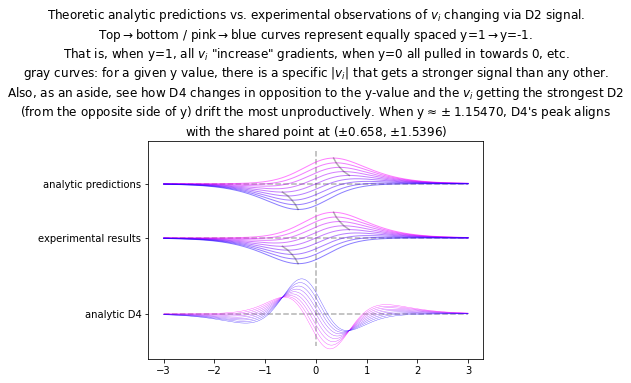

In [453]:
shift_ = 2.5
shift2_ = 6
scale_ = 50
# shift_ = min(wtc, key=lambda x:x[1])[1] * 2.1 * scale_

# plot axes
# plt.plot([0,0], [1.5,-shift_-1.5], '--', color=[0,0,0,0.3])
plt.plot([0,0], [1.5,-shift2_-1.5], '--', color=[0,0,0,0.3])
plt.plot([-3,3], [0,0], '--', color=[0,0,0,0.3])
plt.plot([-3,3], [-shift_, -shift_], '--', color=[0,0,0,0.3])
plt.plot([-3,3], [-shift2_, -shift2_], '--', color=[0,0,0,0.3])
plt.yticks([-shift_,0, -shift2_], ['experimental results','analytic predictions', 'analytic D4'])

extrema1, extrema2=[],[]
for yval_itr, y_val in enumerate(Y_values):
    # plot analytic results
    Plot(lambda x:d2_tanh(x,y_val), color=[1.-yval_itr/len(Y_values),0,1,0.5], lw=1)   
    
    # plot experimental results
    single_out_curve=wtc[yval_itr*V_values.shape[0]:(yval_itr+1)*V_values.shape[0]]
    plt.plot([w[0] for w in single_out_curve], 
             [-scale_*w[1]-shift_ for w in single_out_curve],
             color=[1.-yval_itr/len(Y_values),0,1,0.5],
             linewidth=1)

    # plot D4 for comparison
    plt.plot(V_values,
             [-0.5*d4_tanh(vi, y_val)-shift2_ for vi in V_values],
              color=[1.-yval_itr/len(Y_values),0,1,0.7],
            linewidth=0.4)

    # get data about the extrema
    extremum2=max(single_out_curve, key=lambda x:abs(x[1]))
    extrema2.append((extremum2[0], -extremum2[1]*scale_-shift_))
    extremum1=max([(vi,d2_tanh(vi,y_val)) for vi in V_values], key=lambda x:abs(x[1]))
    extrema1.append(extremum1)
    if y_val==0: 
        extrema1.append((-extremum1[0], -extremum1[1]))
        extrema2.append((-extremum2[0], extremum2[1]*scale_-shift_))
    print(extremum1, extremum2)

        
# point out the peaks of the D2 curves, ie the values of vi that get the most signal per y.
plt.plot([e[0] for e in extrema1 if e[0]<0],[e[1] for e in extrema1 if e[0]<0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema1 if e[0]>0],[e[1] for e in extrema1 if e[0]>0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema2 if e[0]<0],[e[1] for e in extrema2 if e[0]<0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema2 if e[0]>0],[e[1] for e in extrema2 if e[0]>0], color=[0,0,0,.3])
    
plt.title(r'Theoretic analytic predictions vs. experimental observations of $v_i$ changing via D2 signal.'+'\n'+
          r'Top$\rightarrow$bottom / pink$\rightarrow$blue curves represent equally spaced y=1$\rightarrow$y=-1.'+'\n'+
          r'That is, when y=1, all $v_i$ "increase" gradients, when y=0 all pulled in towards 0, etc.'+'\n'+
          r'gray curves: for a given y value, there is a specific $|v_i|$ that gets a stronger signal than any other.'+'\n'+
          r'Also, as an aside, see how D4 changes in opposition to the y-value and the $v_i$ getting the strongest D2'+'\n'+
          r"(from the opposite side of y) drift the most unproductively. When y$\approx\pm$1.15470, D4's peak aligns"+'\n'+
          r"with the shared point at ($\pm$0.658, $\pm$1.5396)"
         )



if 0:
    savefig_utf_timestamp=dt.now().strftime('%m_%d-%H_%M_%S')
    print(savefig_utf_timestamp)
    plt.savefig('figures/fig_'+savefig_utf_timestamp+'.pdf', bbox_inches='tight')
if 0:   
    plt.show()

In addition to the existence of most responsive regions for different v values per y, it also is apparent that when |y| is less than 1 then there are actually vi that are pushed in the *opposite* direction of y; if that was the only change, then the network would perform *worse*. Specifically, these small regions are between v_i=y and sigma(v_i)=y.

When y=1, the strongest D2 signal is felt at v_i=-0.3466. At y=0.5, max |v_i| is at -0.4651, with the alternative counterproductive region existing between v_i between 0.5 and 0.5493 and reaching a local max at 1.0144. (Specifically, the ratio of the peaks is about 6.898 when y=0.5. =0.7581/0.1099 for unscaled tanh.) For comparison, when y=0, the peaks are at (+/- .6585, -/+ .3849). 